<img src='http://linked.earth/FROGS/images/Pyrateslogo.jpg' width="400">


# Chapter 3: Measures of association

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751) & [Jordan Landers](https://orcid.org/0000-0001-9772-7617), University of Southern California


In this notebook we explore the relationship between two well-known climate indices, the Southern Oscillation Index (SOI) and the North Atlantic Oscillation (NAO) index.  The NAO and SOI index have been alleged to show some relationship, albeit a subtle one, in some seasons/epochs.
Specifically, we will explore:
- effects of trends
- effects of autocorrelation 
- various measures of association
- various methods of establishing the significance of a relationship 

## Data Wrangling
- The NAO data are from [NCEP](https://www.ncei.noaa.gov/access/monitoring/nao/)
- The SOI data ship with `Pyleoclim`, which houses a few datasets that make it easy to experiment with real-world geoscientific timeseries. To see what is available, do:

In [1]:
import pyleoclim as pyleo
pyleo.utils.available_dataset_names()

['SOI',
 'NINO3',
 'HadCRUT5',
 'AIR',
 'LR04',
 'AACO2',
 'EDC-dD',
 'GISP2',
 'cenogrid_d18O',
 'cenogrid_d13C']

To load the SOI, simply do:

In [2]:
SOI = pyleo.utils.load_dataset('SOI')
SOI

{'archiveType': 'Instrumental', 'label': 'Southern Oscillation Index'}


None
Time [year C.E.]
1951.000000    1.5
1951.083333    0.9
1951.166667   -0.1
1951.250000   -0.3
1951.333333   -0.7
              ... 
2019.583333   -0.1
2019.666667   -1.2
2019.750000   -0.4
2019.833333   -0.8
2019.916667   -0.6
Name: SOI [mb], Length: 828, dtype: float64

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year C.E.]', ylabel='SOI [mb]'>)

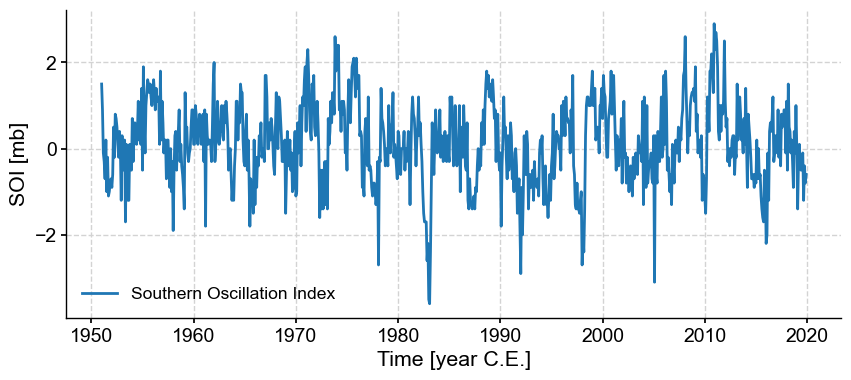

In [3]:
SOI.plot()

That was the easy part. For the NAO index, we have to work a little harder. 

In [5]:
import pandas as pd
url = 'https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table'
df_nao = pd.read_csv(url, sep='\s+', header=0, index_col=0)
df_nao

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1950,0.92,0.40,-0.36,0.73,-0.59,-0.06,-1.26,-0.05,0.25,0.85,-1.26,-1.02
1951,0.08,0.70,-1.02,-0.22,-0.59,-1.64,1.37,-0.22,-1.36,1.87,-0.39,1.32
1952,0.93,-0.83,-1.49,1.01,-1.12,-0.40,-0.09,-0.28,-0.54,-0.73,-1.13,-0.43
1953,0.33,-0.49,-0.04,-1.67,-0.66,1.09,0.40,-0.71,-0.35,1.32,1.04,-0.47
1954,0.37,0.74,-0.83,1.34,-0.09,-0.25,-0.60,-1.90,-0.44,0.60,0.40,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...
2020,1.34,1.26,1.01,-1.02,-0.41,-0.15,-1.23,0.12,0.98,-0.65,2.54,-0.30
2021,-1.11,0.14,0.73,-1.43,-1.24,0.77,0.03,-0.28,-0.21,-2.29,-0.18,0.29
2022,1.08,1.68,0.77,-0.36,0.71,-0.12,-0.09,1.47,-1.61,-0.72,0.69,-0.15
2023,1.25,0.92,-1.11,-0.63,0.39,-0.58,-2.17,-1.16,-0.44,-2.03,-0.32,1.94


Here we have a challenge: the data present themselves as a 2-dimensional table, and need to be reshaped into a 1-D series by somehow combining months and years in a sequential fashion. Fear not! `Pandas` can do!

First, we turn the index as a column called Year:

In [6]:
df_nao = df_nao.reset_index().rename(columns={'index':'Year'})
df_nao

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1950,0.92,0.40,-0.36,0.73,-0.59,-0.06,-1.26,-0.05,0.25,0.85,-1.26,-1.02
1,1951,0.08,0.70,-1.02,-0.22,-0.59,-1.64,1.37,-0.22,-1.36,1.87,-0.39,1.32
2,1952,0.93,-0.83,-1.49,1.01,-1.12,-0.40,-0.09,-0.28,-0.54,-0.73,-1.13,-0.43
3,1953,0.33,-0.49,-0.04,-1.67,-0.66,1.09,0.40,-0.71,-0.35,1.32,1.04,-0.47
4,1954,0.37,0.74,-0.83,1.34,-0.09,-0.25,-0.60,-1.90,-0.44,0.60,0.40,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2020,1.34,1.26,1.01,-1.02,-0.41,-0.15,-1.23,0.12,0.98,-0.65,2.54,-0.30
71,2021,-1.11,0.14,0.73,-1.43,-1.24,0.77,0.03,-0.28,-0.21,-2.29,-0.18,0.29
72,2022,1.08,1.68,0.77,-0.36,0.71,-0.12,-0.09,1.47,-1.61,-0.72,0.69,-0.15
73,2023,1.25,0.92,-1.11,-0.63,0.39,-0.58,-2.17,-1.16,-0.44,-2.03,-0.32,1.94


Next, we invoke `pandas`' powerful [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function to unpivot the table:

In [7]:
df_nao = df_nao.melt(id_vars='Year', var_name='Month', value_name='NAO')
df_nao

,Year,Month,NAO
0,1950,Jan,0.92
1,1951,Jan,0.08
2,1952,Jan,0.93
3,1953,Jan,0.33
4,1954,Jan,0.37
...,...,...,...
895,2020,Dec,-0.30
896,2021,Dec,0.29
897,2022,Dec,-0.15
898,2023,Dec,1.94


Next we combine year and month into a date, then ditch the superfluous year and month columns:

In [8]:
df_nao['date']=(df_nao
          .assign(Date=lambda x: pd.to_datetime(x['Year'].astype(str) + '-' + x['Month'], format='%Y-%b')))['Date']             
df_nao = df_nao.drop(columns=['Year', 'Month']).set_index('date').sort_index()
df_nao

,NAO
date,
1950-01-01,0.92
1950-02-01,0.40
1950-03-01,-0.36
1950-04-01,0.73
1950-05-01,-0.59
...,...
2024-08-01,NaN
2024-09-01,NaN
2024-10-01,NaN


Note the use of a [lambda function](https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/) to rework month and year on the fly. Now we have a proper dataframe with a time axis that is a proper [datetime object](https://docs.python.org/3/library/datetime.html), which `Pyleoclim` will know what do to with:

In [9]:
df_nao.index

DatetimeIndex(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
               '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
               '1950-09-01', '1950-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='date', length=900, freq=None)

<Axes: xlabel='date'>

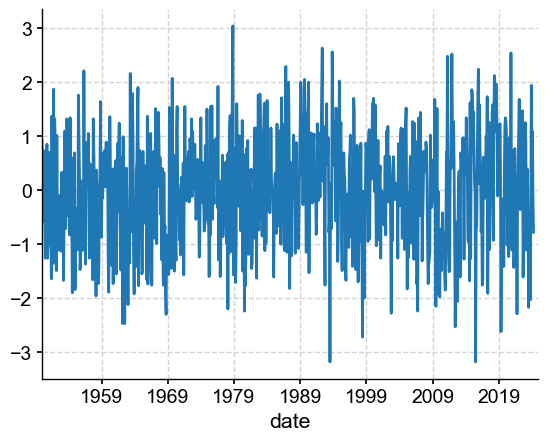

In [10]:
df_nao['NAO'].plot()

Now all we need to do to turn this into a `Pyleoclim` Series object is to sprinkle a little metadata. 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [years CE]', ylabel='NAO'>)

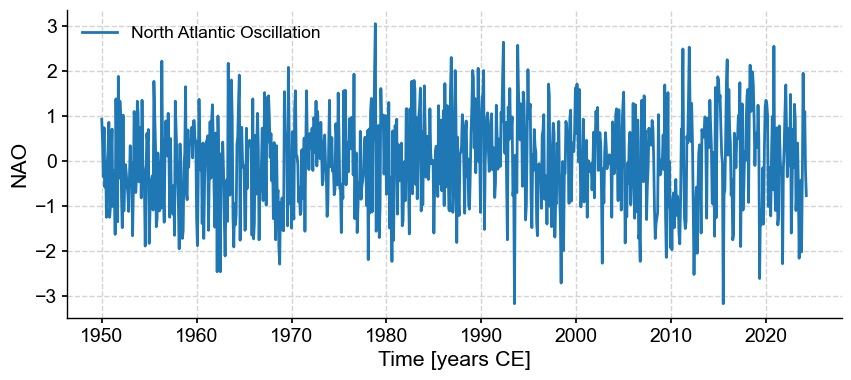

In [11]:
metadata = {
        'time_unit': 'years CE',
        'time_name': 'Time',
        'value_name': 'NAO',
        'label': 'North Atlantic Oscillation',
        'archiveType': 'Instrumental',
        'importedFrom': 'NOAA/NCEI',
    }

NAO = pyleo.Series.from_pandas(df_nao['NAO'],metadata)
NAO.plot()

It turns out that this verison has gaps, which we need to fill by interpolation so other methods work properly:

<Axes: xlabel='Time [years CE]', ylabel='NAO'>

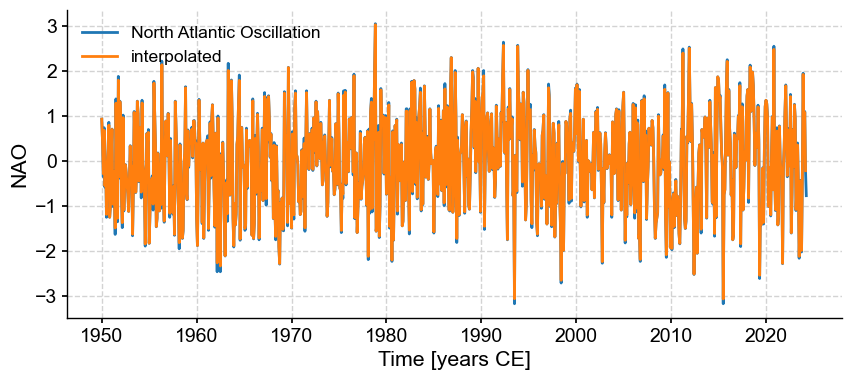

In [12]:
NAOi = NAO.interp(step=1/12)
fig, ax = NAO.plot()
NAOi.plot(ax=ax, label='interpolated')

Let us now look at SOI and NAO side by side:

(<Figure size 640x480 with 3 Axes>,
 {0: <Axes: ylabel='NAO'>,
  1: <Axes: ylabel='SOI [mb]'>,
  'x_axis': <Axes: xlabel='Time [year C.E.]'>})

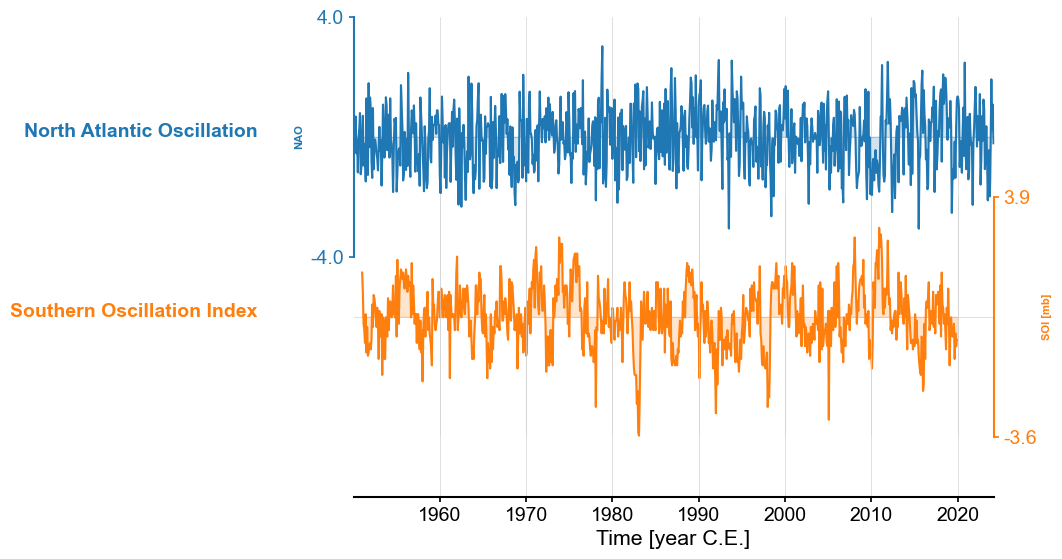

In [13]:
ms = NAOi & SOI
ms.stackplot()

The series have comparable length, and SOI seems, by eye, to dislay stronger internnual variability. We could confirm this by spectral analysis, but this is not the object of this tutorial. Let's dive into exploring their relationship, if any.



## Measuring Association

Here we will use the [Pyleoclim's correlation() function](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.correlation) to measure association between SOI and NAO. 

In [14]:
corr_base = SOI.correlation(NAOi, method='built-in')
print(corr_base)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0011608       0.97  False



We see a very small correlation, with (under this particular test) a large p-value that does not allow to claim that this correlation is significant (i.e. remarkable) in any way. At this point you should be asking yourself what the underlying null hypothesis is. [This link](https://online.stat.psu.edu/stat501/lesson/1/1.9) might be helpful in recalling that, and the assumptions of this standard test. 

Note that the function allows to use a bunch of [different statistics to measure association](https://docs.scipy.org/doc/scipy/reference/stats.html#association-correlation-tests):

In [15]:
for stat in ['pearsonr','spearmanr','pointbiserialr','kendalltau','weightedtau']:
     corr = SOI.correlation(NAOi, statistic=stat, number=200)
     print(f'{stat}(NAO,SOI)={corr.r:.3f}, p={corr.p:.3f}')   

Evaluating association on surrogate pairs: 100%|██████████| 200/200 [00:00<00:00, 1454.68it/s]

pearsonr(NAO,SOI)=0.001, p=0.980



Evaluating association on surrogate pairs: 100%|██████████| 200/200 [00:00<00:00, 1935.64it/s]


spearmanr(NAO,SOI)=-0.002, p=0.990


Evaluating association on surrogate pairs: 100%|██████████| 200/200 [00:00<00:00, 1415.85it/s]


pointbiserialr(NAO,SOI)=0.001, p=0.975


Evaluating association on surrogate pairs: 100%|██████████| 200/200 [00:00<00:00, 2191.02it/s]


kendalltau(NAO,SOI)=-0.001, p=0.970


Evaluating association on surrogate pairs: 100%|██████████| 200/200 [00:00<00:00, 389.44it/s]

weightedtau(NAO,SOI)=-0.035, p=0.675


We see that no matter which way we slice it, we get very small numbers, which appear insignificant with respect to the default test. 

## Spurious Correlations

In the geosciences, there are two process that might artificially increase correlations between otherwise unrelated variables
1. smoothing
2. common trends

### Smoothing-enhanced correlations

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year C.E.]', ylabel='value'>)

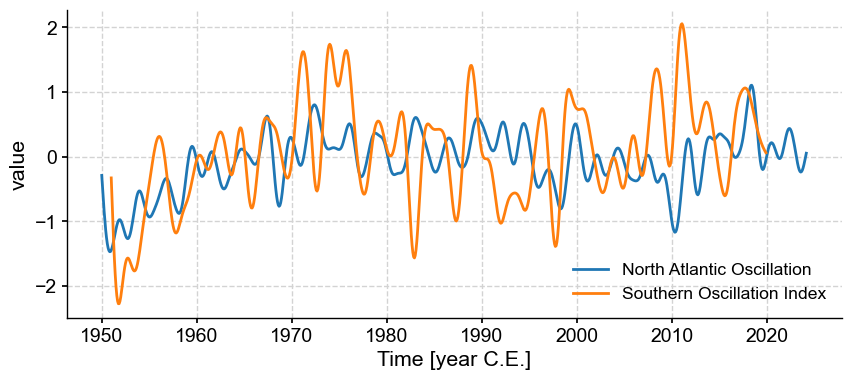

In [16]:
ms_md = ms.filter(method='butterworth',cutoff_scale=[2, 50])
ms_md.plot()

In [17]:
corr_md=ms_md.series_list[0].correlation(ms_md.series_list[1],method='built-in')
print(corr_md)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.306343  < 1e-18    True



We see that we sufficient smoothing, we have increased the correlation to a point that it is now highly significant (note the infinitesimal p-value). Bu BEWARE! The built-in test for Pearson's correlation, as recalled above, assumes that the data are IID: independent and identically distributed. After smoothing so heavily, neighboring values now resemble each other a lot, so independence is lost (see course notes for more details). So now we need to bring more sophisticated methods to gauge the p-values. 
First, let's use a common analytical approximation to adjust for the loss of degrees of freedom (see course notes). This is coded up in `Pyleoclim` as `ttest`:

In [18]:
corr_md_dof=ms_md.series_list[0].correlation(ms_md.series_list[1],method='ttest')
print(corr_md_dof)

AssertionError: Too few effective d.o.f. to apply this method!

That didn't work! As the error message implies, the smoothing has lowered the effective degrees of freedom to such an extent this method won't work. Then let's use a parametric Monte Carlo test:  AR(1) benchmarks. 

In [19]:
corr_md_ar1=ms_md.series_list[0].correlation(ms_md.series_list[1],method='ar1sim', number=5000, seed = 222)
print(corr_md_ar1)

Evaluating association on surrogate pairs: 100%|██████████| 5000/5000 [00:03<00:00, 1487.20it/s]

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.306343       0.35  False



The correlation has not changed, but see what happened to the p-value! We can actually quantify this:

In [20]:
corr_md_ar1.p/corr_md.p

1.8258770939061737e+18

This is how much larger the p-value is under this test! So we got from highly significant to insignificant. Would we have found the same with the non-parametric Monte Carlo test (phase-randomization)?  

In [21]:
corr_md_pr=ms_md.series_list[0].correlation(ms_md.series_list[1],method='phaseran', number=5000, seed = 222)
print(corr_md_pr)

Evaluating association on surrogate pairs: 100%|██████████| 5000/5000 [00:03<00:00, 1434.84it/s]

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.306343       0.02  True



In this case, the two methods disagree, and phase-randomization appears more lenient. Disagreements between methods are frequent when there are relatively few degrees of freedom, and are cause for caution. 

**Take-home message: beware the effect of smoothing on the degrees of freedom, and assessments of significance.**

### Trend-enhanced correlations

Now we look at a slightly different issue: how the presence of common trends may make otherwise unrelated timeseries appear artificially related. First, let's apply the [common_time](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multipleseries.MultipleSeries.common_time) method to obtain a common time vector to both series, from which we'll construct the trend:

In [22]:
msc = ms.common_time()
tc = msc.series_list[0].time # would get the same answer with msc.series_list[`].time

The baseline trend will look something like this, which we'll superimpose on the NAO and SOI indices, respectively.

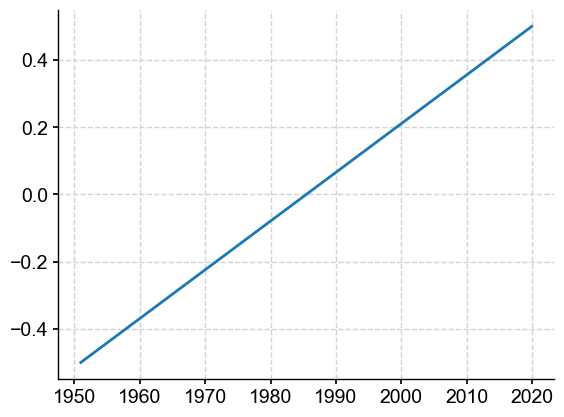

In [23]:
trend = (tc-tc.mean())/tc.ptp() # create trend as a NumPy array
import matplotlib.pyplot as plt
plt.plot(tc, trend) # plot it

In [24]:
scales = [0.5, 1, 2]
for method in ['built-in','ttest','ar1sim','phaseran']:
    for s in scales:
        scaled_trend = s*trend # create trend as a NumPy array
        nao_t = msc.series_list[0].copy() # create copy of the NAO series
        nao_t.value += scaled_trend # add trend
        soi_t = msc.series_list[1].copy() # create copy of the SOI series
        soi_t.value += scaled_trend # add trend
        corr_t = nao_t.correlation(soi_t,method=method)
        print(f"Scale = {s}, using {method} method\n")
        print(corr_t)

Scale = 0.5, using built-in method

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0279778       0.42  False

Scale = 1, using built-in method

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    0.0924265  < 1e-2     True

Scale = 2, using built-in method

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.277871  < 1e-15    True

Scale = 0.5, using ttest method

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0279778       0.46  False

Scale = 1, using ttest method

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0924265       0.02  True

Scale = 2, using ttest method

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.277871  < 1e-12    True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1523.83it/s]


Scale = 0.5, using ar1sim method

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0279778       0.44  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1531.31it/s]


Scale = 1, using ar1sim method

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0924265       0.03  True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1537.74it/s]


Scale = 2, using ar1sim method

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.277871  < 1e-6     True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1452.27it/s]


Scale = 0.5, using phaseran method

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0279778       0.55  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1513.72it/s]


Scale = 1, using phaseran method

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    0.0924265       0.15  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1389.75it/s]

Scale = 2, using phaseran method

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.277871  < 1e-2     True



As we dial up the amplitude of the trend (1/2, 1, 2x the original trend), we see that the correlation goes from 0.028, to 0.09, to 0.28. The built-in method, being easily fooled, declares all three as significant. The other methods are more resilient, but when the trend is large enough (2), all of them call the correlation significant.  The t-test with adjusted degrees of freedom (DOFs) gives downright counterinuitive results: it calls 0.028 significant,  0.09 insignificant, and 0.28 significant again. In this case, phase randomization is the most conservative. This is why it is the default method in `Pyleoclim`. 

**Take-home message: common trends can easily create the appearance of correlations (see [Tyler Vigen's excellent website](https://www.tylervigen.com/spurious-correlations)) and really complicate assessments of significance.** If the trend is not relevant to your question, we recommend removing it prior to computing correlations, e.g. using `Pyleoclim's` [detrend()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.detrend).  


## Takeways

Not only is correlation not indicative of causation, but spurious correlations abound, often driven by smoothing, trends, or short sample sizes. Some null hypotheses are more stringent than others, but the built-in one nearly always assumed IID data, which is hardly ever verified in the geosciences. Make you carefully match your null hypothesis to your data/problem. 

If if it causality you are after, more advanced tools are available, like [Empirical Dynamical Modeling](https://sugiharalab.github.io/EDM_Documentation/). It is well worth a dive into the underlying theory, but it is undoubtedly more complex.
